<a href="https://colab.research.google.com/github/obVdo/blood_cells_dl/blob/main/file_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Collab cannot perform some functionalities of non-dev fastai 😞

In [ ]:
!pip install --upgrade git+https://github.com/fastai/fastai.git

In [2]:
import os

In [3]:
import fastbook
fastbook.setup_book()

In [4]:
from fastbook import *

In [5]:
!git clone https://github.com/obVdo/blood_cells_dl

fatal: destination path 'blood_cells_dl' already exists and is not an empty directory.


In [6]:
path = Path("/content/blood_cells_dl/data/images/TRAIN")

In [7]:
fns = get_image_files(path)


In [8]:
failed = verify_images(fns)
failed

(#0) []

In [9]:
?DataBlock

In [10]:
blood = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2),
    get_y = parent_label,
    item_tfms = Resize(240, ResizeMethod.Squish, pad_mode="zeros"),
   
    
)

In [11]:
dls = blood.dataloaders(path)

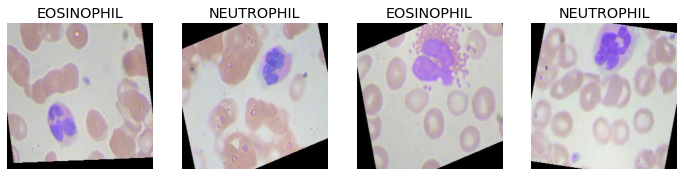

In [12]:
dls.valid.show_batch(max_n=4, nrows=1)

In [13]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)


Learning rate for randomly added layer. The cnn learner inherently freezes the pretarained layers.

SuggestedLRs(valley=0.0014454397605732083)

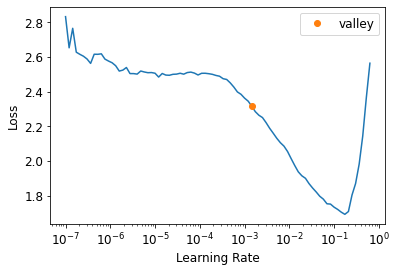

In [14]:
 learn.lr_find()

In [15]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.541069,0.114591,0.046208,02:30
1,0.108012,0.048742,0.019086,02:30
2,0.032909,0.029161,0.011552,02:30


In [16]:
learn.unfreeze()

SuggestedLRs(valley=1.4454397387453355e-05)

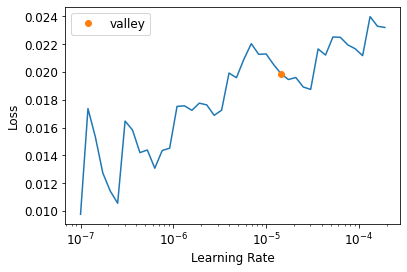

In [17]:
learn.lr_find()


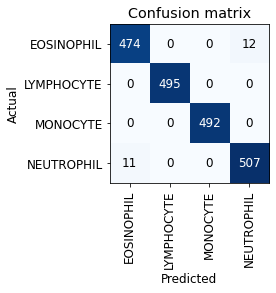

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


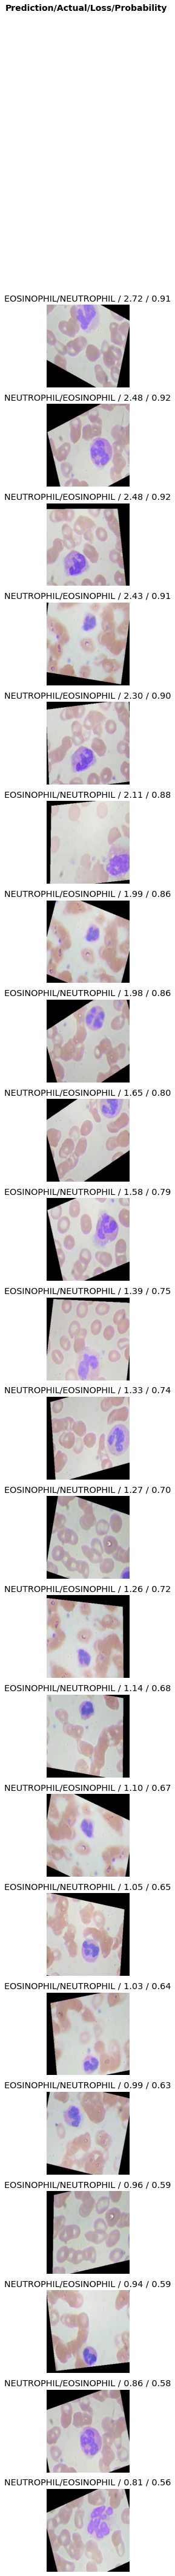

In [45]:
interp.plot_top_losses(23, nrows=23)


Some of the images seems to be labelled wrong or out of frame, lets get the paths to these and manually check them by googling blood cells 🤔

In [29]:
interp2 = ClassificationInterpretation.from_learner(learn)

In [44]:
interp2.top_losses(23)[1]


TensorBase([ 359,  642,  323, 1757, 1838,  792,  690,  112,  857, 1590,  504,  113,  655, 1759, 1692,  134, 1709,  641, 1361, 1897, 1681,  354, 1974])

In [64]:
sus_paths = [dls.valid_ds.items[x] for x in array(interp2.top_losses(23)[1]) ]

In [67]:
for o in sus_paths:
  if Path.exists(o):
    Path.unlink(o) 

One of the path from sus_paths.

In [68]:
Path.exists(Path('/content/blood_cells_dl/data/images/TRAIN/EOSINOPHIL/_29_9090.jpeg'))

False

Maybe there is an easier way to do this. Seems redundant.

In [69]:
dls = blood.dataloaders(path)

In [70]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)


SuggestedLRs(valley=0.001737800776027143)

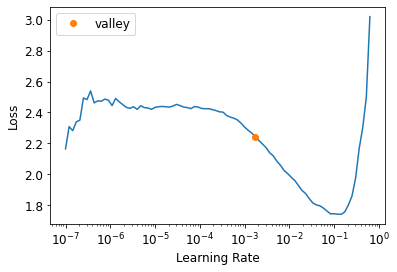

In [71]:
 learn.lr_find()

In [72]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.506548,0.117383,0.048842,02:30
1,0.103559,0.042485,0.013092,02:30
2,0.033289,0.027901,0.009567,02:30


In [73]:
learn.unfreeze()

SuggestedLRs(valley=2.0892961401841603e-05)

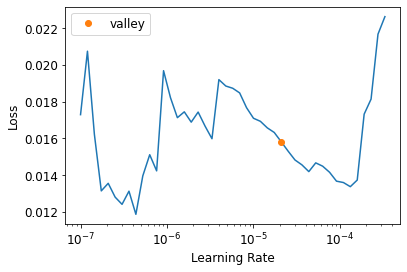

In [74]:
 learn.lr_find()

Let me try without training earlier layers.

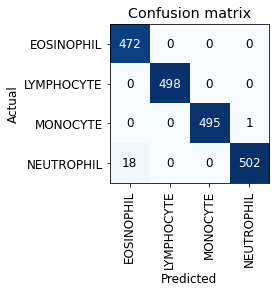

In [75]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [76]:
learn.fit_one_cycle(6, lr_max=slice(1e-6,1e-5))


epoch,train_loss,valid_loss,error_rate,time
0,0.017941,0.027875,0.009063,03:28
1,0.016524,0.023411,0.010070,03:28
2,0.010218,0.019080,0.008056,03:28
3,0.006632,0.019677,0.007553,03:28
4,0.004810,0.014441,0.005539,03:28
5,0.006624,0.015925,0.005539,03:28


In [77]:
learn.export(fname="resnet34_model.pkl")


In [78]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('resnet34_model.pkl')]

In [79]:
learn_inf = load_learner(path/'resnet34_model.pkl')


In [80]:
learn_inf.predict("/content/blood_cells_dl/data/images/TEST/EOSINOPHIL/_0_1616.jpeg")[0]

'EOSINOPHIL'

In [81]:
i = 0
for o in get_image_files(Path("/content/blood_cells_dl/data/images/TEST")):
  
  if o.parents[0].name != learn_inf.predict(o)[0]:
    i += 1



In [82]:
error_rate_test_data = i*100 /len(get_image_files(Path("/content/blood_cells_dl/data/images/TEST")))

In [83]:
error_rate_test_data

14.796944109368717